[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2026/blob/main/Lab1-NetworkSci-PSN/notebooks/02-pasient_likhetsnettverk_iris.ipynb)


Versjon 2025.12.02 - A. Lundervold

Lab 1: bruk `elmed219-2025` conda-miljøet


# Pasient-likhetsnettverk med IRIS-data

## En praktisk introduksjon til nettverksbasert likhetsanalyse


## 🌸 Hvorfor IRIS-blomster?

I denne notebooken skal vi lære å bygge **pasient-likhetsnettverk** (Patient Similarity Networks, PSN). Men i stedet for å starte med komplekse pasientdata, bruker vi det klassiske IRIS-blomsterdatasettet som et pedagogisk eksempel.

**Tenk på det slik:**
- Hver blomst er som en "pasient"
- De fire målingene (kronbladlengde, -bredde, osv.) er som "kliniske variabler"
- De tre artene (setosa, versicolor, virginica) er som "diagnosegrupper"

Dette datasettet er ideelt for å lære PSN fordi:
1. **Velkjent** – de fleste har møtt det før, så vi kan fokusere på metodikken
2. **Passende størrelse** – 150 datapunkter gir meningsfulle nettverk uten å være overveldende
3. **Tydelige klynger** – demonstrerer community detection på en intuitiv måte
4. **4 features** – enkelt nok til å forstå matematikken


## 🎯 Læringsmål

Etter denne notebooken skal du kunne:

1. Forstå hvordan man bygger et likhetsnettverk fra feature-data
2. Beregne likhet mellom datapunkter ved hjelp av Euklidsk avstand
3. Visualisere nettverk med NetworkX
4. Tolke nettverksstrukturer og hva de sier om dataene
5. Anvende community detection for å finne naturlige grupperinger
6. Overføre disse konseptene til kliniske pasientdata


---
## Steg 1: Last inn nødvendige biblioteker


In [2]:
# Undertrykk advarsler for renere output
import warnings
warnings.filterwarnings('ignore', message='scipy._lib.messagestream.MessageStream size changed')

# Numeriske beregninger og databehandling
import numpy as np
import pandas as pd

# Visualisering
import matplotlib.pyplot as plt
import seaborn as sns

# Nettverksanalyse
import networkx as nx

# Data
from sklearn.datasets import load_iris

# Hjelpefunksjoner
import matplotlib.patches as mpatches
from IPython.display import display, Markdown, HTML
from typing import Dict, List, Tuple

print("Alle biblioteker er lastet inn! ✓")


Alle biblioteker er lastet inn! ✓


---
## Steg 2: Last inn og utforsk IRIS-datasettet


In [3]:
# Last inn IRIS-datasettet
iris = load_iris()

# Pakk ut data
X = iris.data    # Features: de 4 målingene for hver blomst
y = iris.target  # Målvariabel: art (0=setosa, 1=versicolor, 2=virginica)
species = iris.target_names  # Artsnavn

print("="*50)
print("IRIS-DATASETTET")
print("="*50)
print(f"Antall blomster: {X.shape[0]}")
print(f"Antall features: {X.shape[1]}")
print(f"\nArter: {list(species)}")
print(f"\nFeatures (målinger):")
for i, name in enumerate(iris.feature_names):
    print(f"  {i+1}. {name}")


IRIS-DATASETTET
Antall blomster: 150
Antall features: 4

Arter: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]

Features (målinger):
  1. sepal length (cm)
  2. sepal width (cm)
  3. petal length (cm)
  4. petal width (cm)


### 🔍 La oss se på noen eksempler


In [4]:
# Lag en pen DataFrame for visning
df = pd.DataFrame(X, columns=iris.feature_names)
df['art'] = [species[i] for i in y]

# Vis de første blomstene fra hver art
print("Eksempler fra datasettet:")
print("\n--- SETOSA (blomst 0-2) ---")
display(df[df['art'] == 'setosa'].head(3))
print("\n--- VERSICOLOR (blomst 50-52) ---")
display(df[df['art'] == 'versicolor'].head(3))
print("\n--- VIRGINICA (blomst 100-102) ---")
display(df[df['art'] == 'virginica'].head(3))


Eksempler fra datasettet:

--- SETOSA (blomst 0-2) ---


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),art
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa



--- VERSICOLOR (blomst 50-52) ---


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),art
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor



--- VIRGINICA (blomst 100-102) ---


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),art
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica
102,7.1,3.0,5.9,2.1,virginica


---
## Steg 3: Opprett en tom graf

Vi bruker NetworkX til å lage en **vektet, urettet graf** $G = (V, E)$ hvor:
- $V$ = noder (blomster/"pasienter")
- $E$ = kanter (forbindelser basert på likhet)


In [5]:
# Opprett en tom, urettet graf
G = nx.Graph()

print("Graf opprettet!")
print(f"Type: {type(G)}")


Graf opprettet!
Type: <class 'networkx.classes.graph.Graph'>


---
## Steg 4: Legg til noder (blomstene)

Hver blomst blir en node i nettverket. Vi lagrer også hvilken art den tilhører som et attributt.


In [6]:
# Legg til en node for hver blomst
for i in range(len(X)):
    G.add_node(i, species=species[y[i]])

print(f"Antall noder i nettverket: {G.number_of_nodes()}")
print(f"\nEksempel på node-attributter:")
print(f"  Node 0: {G.nodes[0]}")
print(f"  Node 50: {G.nodes[50]}")
print(f"  Node 100: {G.nodes[100]}")


Antall noder i nettverket: 150

Eksempel på node-attributter:
  Node 0: {'species': np.str_('setosa')}
  Node 50: {'species': np.str_('versicolor')}
  Node 100: {'species': np.str_('virginica')}


---
## Steg 5: Beregn likhet og legg til kanter

### 📐 Matematisk forklaring

For å bygge et likhetsnettverk må vi definere hvor "like" to blomster er. Vi gjør dette i to steg:

#### 1. Euklidsk avstand
For to blomster $i$ og $j$ med feature-vektorer $X_i$ og $X_j$ i 4D-rom:

$$d_{ij} = \|X_i - X_j\| = \sqrt{\sum_{k=1}^4 (X_{i,k} - X_{j,k})^2}$$

hvor $X_{i,k}$ er den $k$-te featuren til blomst $i$.

#### 2. Transformasjon til likhet
Avstand er det motsatte av likhet. Vi transformerer derfor:

$$s_{ij} = \frac{1}{1 + d_{ij}}$$

**Egenskaper ved denne transformasjonen:**
- $s_{ij} \in (0, 1]$ – likheten er begrenset mellom 0 og 1
- Når $d_{ij} = 0$ (identiske blomster): $s_{ij} = 1$
- Når $d_{ij} \to \infty$: $s_{ij} \to 0$
- Symmetrisk: $s_{ij} = s_{ji}$


### 🧮 Eksempelberegning

La oss beregne likheten mellom blomst 0 og blomst 1:


In [7]:
# Vis målingene for blomst 0 og 1
print("Blomst 0 (setosa):", X[0])
print("Blomst 1 (setosa):", X[1])

# Beregn Euklidsk avstand steg for steg
diff = X[0] - X[1]
print(f"\nForskjell (X_0 - X_1): {diff}")

squared_diff = diff ** 2
print(f"Kvadrert forskjell: {squared_diff}")

sum_squared = np.sum(squared_diff)
print(f"Sum av kvadrater: {sum_squared:.4f}")

distance = np.sqrt(sum_squared)
print(f"Euklidsk avstand: {distance:.4f}")

# Transformer til likhet
similarity = 1 / (1 + distance)
print(f"\nLikhet: {similarity:.4f}")


Blomst 0 (setosa): [5.1 3.5 1.4 0.2]
Blomst 1 (setosa): [4.9 3.  1.4 0.2]

Forskjell (X_0 - X_1): [0.2 0.5 0.  0. ]
Kvadrert forskjell: [0.04 0.25 0.   0.  ]
Sum av kvadrater: 0.2900
Euklidsk avstand: 0.5385

Likhet: 0.6500


### Legg til alle kanter


In [8]:
# Beregn likhet mellom alle par av blomster og legg til kanter
for i in range(len(X)):
    for j in range(i+1, len(X)):  # Unngå duplikater (i,j) og (j,i)
        # Beregn Euklidsk avstand
        distance = np.linalg.norm(X[i] - X[j])
        
        # Transformer til likhet
        similarity = 1 / (1.0 + distance)
        
        # Legg til kant med likhet som vekt
        G.add_edge(i, j, weight=similarity)

print(f"Antall kanter: {G.number_of_edges()}")
print(f"\n(For 150 noder er maks antall kanter = 150*149/2 = {150*149//2})")

# Vis noen eksempler på kanter
print("\nEksempler på kantvekter (likhet):")
for i, (u, v, data) in enumerate(G.edges(data=True)):
    if i >= 5:
        break
    print(f"  Kant {u} — {v}: likhet = {data['weight']:.3f}")


Antall kanter: 11175

(For 150 noder er maks antall kanter = 150*149/2 = 11175)

Eksempler på kantvekter (likhet):
  Kant 0 — 1: likhet = 0.650
  Kant 0 — 2: likhet = 0.662
  Kant 0 — 3: likhet = 0.607
  Kant 0 — 4: likhet = 0.876
  Kant 0 — 5: likhet = 0.619


---
## Steg 6: Visualiser nettverket 🎨

Nå kommer det spennende – å se nettverket! Vi farger nodene etter art og kantene etter likhetsstyrke.


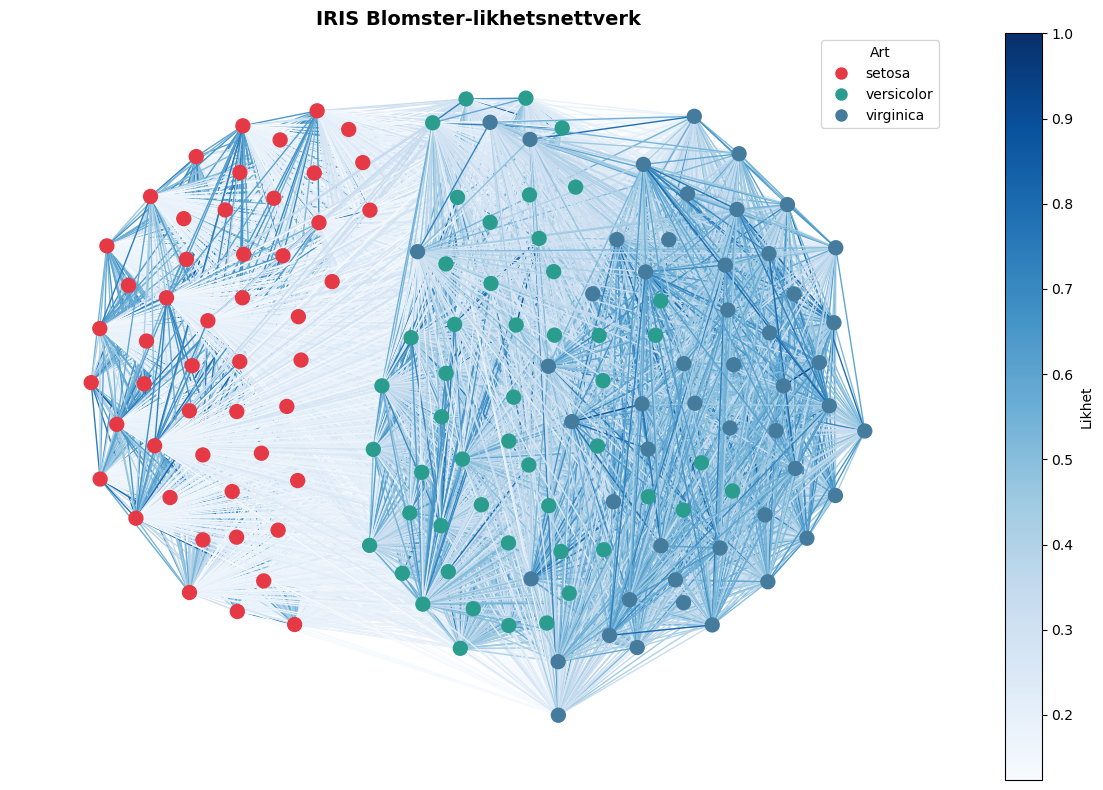

In [9]:
# Opprett figur
fig, ax = plt.subplots(figsize=(12, 8))

# Definer farger for hver art
color_dict = {
    'setosa': '#E63946',      # Rød
    'versicolor': '#2A9D8F',  # Grønn
    'virginica': '#457B9D'    # Blå
}

# Lag fargeliste for noder basert på art
color_map = [color_dict[G.nodes[node]['species']] for node in G.nodes]

# Hent kantvekter for farging av kanter
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Beregn layout (spring layout simulerer krefter mellom nodene)
pos = nx.spring_layout(G, k=1, seed=42)

# Tegn nettverket
nx.draw(G, 
        pos=pos,
        node_color=color_map,
        edge_color=edge_weights,
        width=1.0,
        edge_cmap=plt.cm.Blues,
        with_labels=False,
        node_size=100,
        ax=ax)

# Legg til forklaring (legend)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=color, label=species_name, markersize=10)
    for species_name, color in color_dict.items()
]
ax.legend(handles=legend_elements, loc='upper right', title='Art')

# Legg til tittel
ax.set_title("IRIS Blomster-likhetsnettverk", fontsize=14, fontweight='bold')

# Legg til fargeskala for kanter
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues)
sm.set_array(edge_weights)
cbar = plt.colorbar(sm, ax=ax, label='Likhet')

plt.tight_layout()
plt.show()


### 🔍 Tolkning av visualiseringen

Legg merke til:

1. **Tre tydelige klynger** – nettverket viser naturlig separasjon mellom de tre artene
2. **Setosa (rød) står alene** – denne arten er tydelig forskjellig fra de to andre
3. **Versicolor og Virginica overlapper** – disse to artene har mer lignende egenskaper
4. **Mørkere kanter innen klynger** – blomster av samme art er mer like hverandre
5. **Lysere kanter mellom klynger** – ulike arter har lavere likhet

**Klinisk analogi:** Tenk deg at de tre klyngene representerer pasienter med ulike sykdomstyper eller behandlingsresponser. Nettverket viser hvem som ligner på hvem!


---
## Steg 7: Nabomatrisen (adjacency matrix)

Nabomatrisen er en matematisk representasjon av nettverket som en matrise. Element $(i,j)$ inneholder likheten mellom node $i$ og $j$.


In [10]:
# Konverter nettverket til en pandas DataFrame
adj_matrix = nx.to_pandas_adjacency(G, weight='weight')

print("Nabomatrisens dimensjoner:", adj_matrix.shape)
print("\nDe første 5×5 elementene:")
display(adj_matrix.iloc[:5, :5].round(3))


Nabomatrisens dimensjoner: (150, 150)

De første 5×5 elementene:


,0,1,2,3,4
0,0.000,0.650,0.662,0.607,0.876
1,0.650,0.000,0.769,0.751,0.622
2,0.662,0.769,0.000,0.803,0.662
3,0.607,0.751,0.803,0.000,0.607
4,0.876,0.622,0.662,0.607,0.000


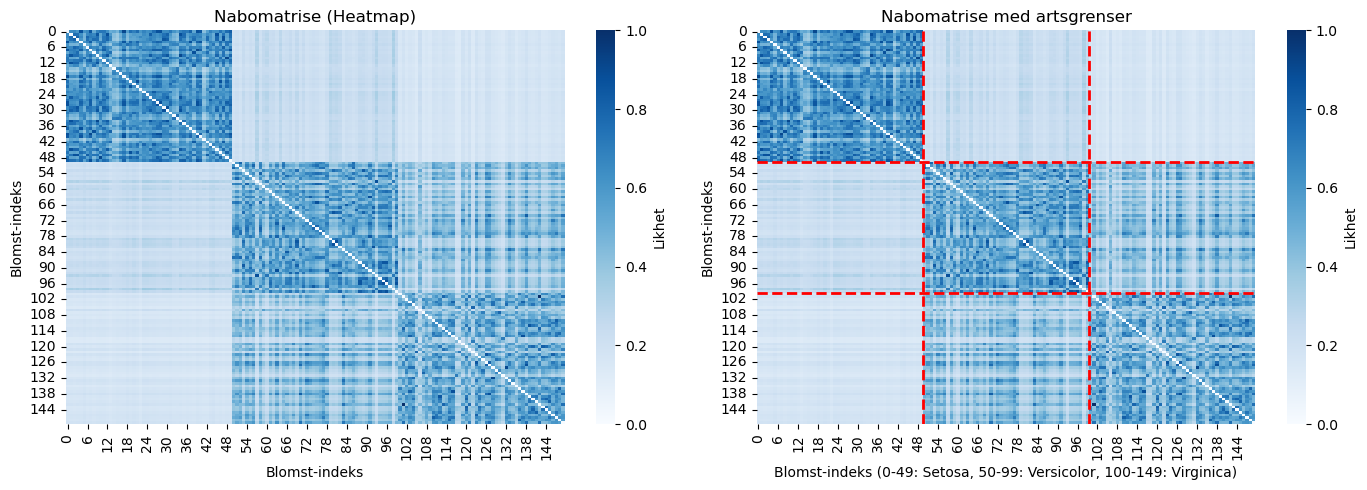


TOLKNING AV NABOMATRISEN

📊 Blokkstruktur:
   • Blokk 0-49:    Setosa (øverst til venstre)
   • Blokk 50-99:   Versicolor (midten)
   • Blokk 100-149: Virginica (nederst til høyre)

📌 Hva ser vi?
   • Mørkere diagonalblokker = høy likhet innad i arter
   • Lysere off-diagonal blokker = lavere likhet mellom arter
   • Setosa-blokken er tydeligst separert (lysest mot andre)
   • Versicolor/Virginica har mer overlapp (mørkere mellom disse)



In [11]:
# Visualiser nabomatrisen som heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Enkel heatmap
sns.heatmap(adj_matrix, cmap='Blues', ax=ax1, cbar_kws={'label': 'Likhet'})
ax1.set_title('Nabomatrise (Heatmap)', fontsize=12)
ax1.set_xlabel('Blomst-indeks')
ax1.set_ylabel('Blomst-indeks')

# Plot 2: Med artsgrenser markert
sns.heatmap(adj_matrix, cmap='Blues', ax=ax2, cbar_kws={'label': 'Likhet'})

# Marker grensene mellom arter (50 blomster per art)
for boundary in [50, 100]:
    ax2.axhline(y=boundary, color='red', linestyle='--', linewidth=2)
    ax2.axvline(x=boundary, color='red', linestyle='--', linewidth=2)

ax2.set_title('Nabomatrise med artsgrenser', fontsize=12)
ax2.set_xlabel('Blomst-indeks (0-49: Setosa, 50-99: Versicolor, 100-149: Virginica)')
ax2.set_ylabel('Blomst-indeks')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TOLKNING AV NABOMATRISEN")
print("="*60)
print("""
📊 Blokkstruktur:
   • Blokk 0-49:    Setosa (øverst til venstre)
   • Blokk 50-99:   Versicolor (midten)
   • Blokk 100-149: Virginica (nederst til høyre)

📌 Hva ser vi?
   • Mørkere diagonalblokker = høy likhet innad i arter
   • Lysere off-diagonal blokker = lavere likhet mellom arter
   • Setosa-blokken er tydeligst separert (lysest mot andre)
   • Versicolor/Virginica har mer overlapp (mørkere mellom disse)
""")


---
## Steg 8: Grunnleggende nettverksanalyse

La oss beregne noen nøkkelmetrikker for å forstå nettverksstrukturen.


In [12]:
print("="*50)
print("NETTVERKSANALYSE")
print("="*50)

# Grunnleggende metrikker
print(f"\n📈 Grunnleggende metrikker:")
print(f"   Gjennomsnittlig klyngekoeffisient: {nx.average_clustering(G):.3f}")
print(f"   Nettverkstetthet: {nx.density(G):.3f}")

# Funksjon for å beregne gjennomsnittlig likhet innad/mellom arter
def calculate_species_similarities(G, y):
    """Beregn gjennomsnittlig likhet innad og mellom arter"""
    within_species = {species_name: [] for species_name in iris.target_names}
    between_species = []
    
    for (i, j, w) in G.edges.data('weight'):
        if y[i] == y[j]:  # Samme art
            within_species[iris.target_names[y[i]]].append(w)
        else:  # Ulik art
            between_species.append(w)
    
    print(f"\n🌸 Gjennomsnittlig likhet INNAD i arter:")
    for species_name, similarities in within_species.items():
        print(f"   {species_name}: {np.mean(similarities):.3f}")
    
    print(f"\n🔗 Gjennomsnittlig likhet MELLOM arter: {np.mean(between_species):.3f}")
    
    # Beregn separasjonsratio
    avg_within = np.mean([np.mean(v) for v in within_species.values()])
    avg_between = np.mean(between_species)
    print(f"\n📊 Separasjonsratio (innad/mellom): {avg_within/avg_between:.2f}x")

calculate_species_similarities(G, y)


NETTVERKSANALYSE

📈 Grunnleggende metrikker:
   Gjennomsnittlig klyngekoeffisient: 1.000
   Nettverkstetthet: 1.000

🌸 Gjennomsnittlig likhet INNAD i arter:
   setosa: 0.614
   versicolor: 0.531
   virginica: 0.495

🔗 Gjennomsnittlig likhet MELLOM arter: 0.264

📊 Separasjonsratio (innad/mellom): 2.07x


### 📖 Forklaring av metrikker

**Klyngekoeffisient = 1.0**: Dette betyr at alle naboer til enhver node også er forbundet med hverandre. Dette er forventet fordi vi har et *komplett* nettverk (alle noder er koblet til alle andre).

**Nettverkstetthet = 1.0**: Alle mulige kanter eksisterer.

**Separasjonsratio > 2**: Blomster av samme art er i gjennomsnitt mer enn dobbelt så like hverandre som blomster av ulik art. Dette bekrefter den tydelige klyngestrukturen vi så i visualiseringen!


---
## Steg 9: Community Detection (Klyngedeteksjon)

Kan vi la algoritmen finne naturlige grupperinger i dataene – uten å "fortelle" den hvilken art hver blomst tilhører?

Vi bruker **Louvain-algoritmen**, som er en populær metode for community detection.


In [13]:
# Importer community detection
import community.community_louvain as community

# Utfør community detection
communities = community.best_partition(G)

# Analyser resultater
n_communities = len(set(communities.values()))
modularity = community.modularity(communities, G)

print("="*50)
print("COMMUNITY DETECTION (Louvain-algoritmen)")
print("="*50)
print(f"\nAntall communities funnet: {n_communities}")
print(f"Modularitet: {modularity:.3f}")
print("\n(Modularitet måler hvor godt nettverket er delt inn i communities.")
print("Verdier over 0.3 indikerer signifikant community-struktur.)")


COMMUNITY DETECTION (Louvain-algoritmen)

Antall communities funnet: 3
Modularitet: 0.179

(Modularitet måler hvor godt nettverket er delt inn i communities.
Verdier over 0.3 indikerer signifikant community-struktur.)


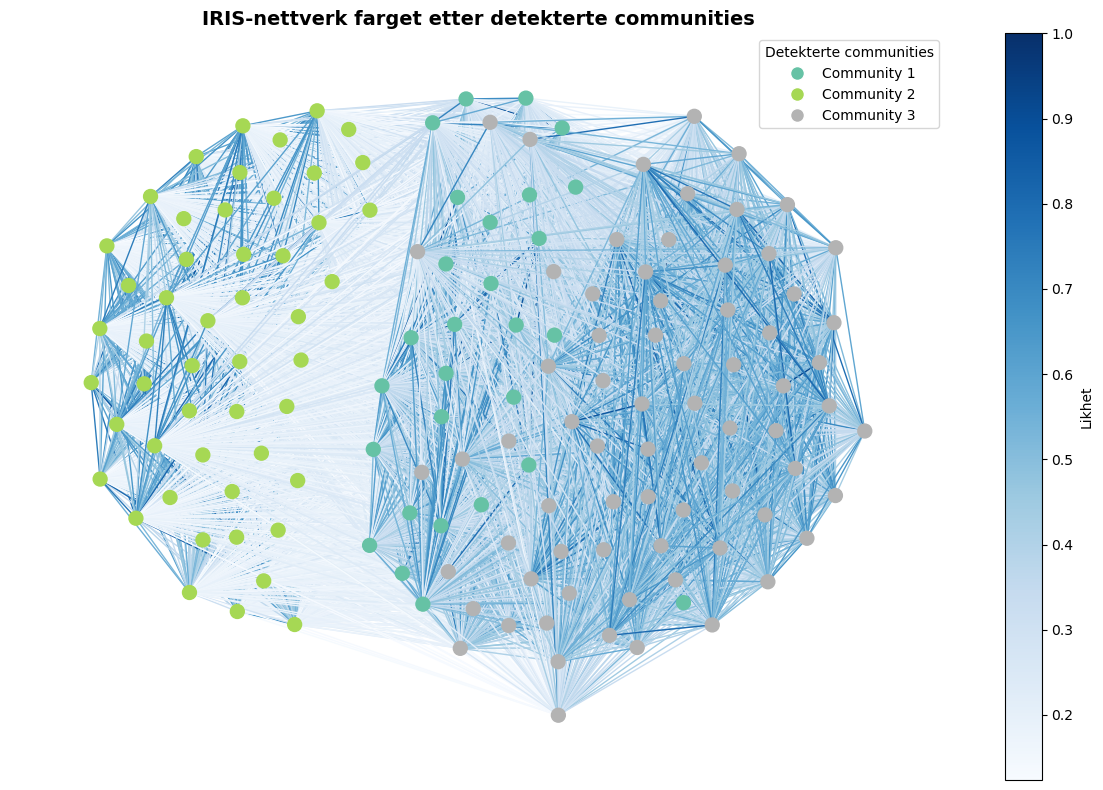

In [14]:
# Visualiser nettverket med community-farger
fig, ax = plt.subplots(figsize=(12, 8))

# Lag farger for communities
community_colors = plt.cm.Set2(np.linspace(0, 1, n_communities))
node_colors = [community_colors[communities[node]] for node in G.nodes()]

# Tegn nettverket
nx.draw(G, 
        pos=pos,  # Bruk samme layout som før
        node_color=node_colors,
        edge_color=edge_weights,
        width=1.0,
        edge_cmap=plt.cm.Blues,
        with_labels=False,
        node_size=100,
        ax=ax)

ax.set_title("IRIS-nettverk farget etter detekterte communities", 
             fontsize=14, fontweight='bold')

# Legg til forklaring
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=community_colors[i], 
               label=f'Community {i+1}', markersize=10)
    for i in range(n_communities)
]
ax.legend(handles=legend_elements, loc='upper right', title='Detekterte communities')

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues)
sm.set_array(edge_weights)
plt.colorbar(sm, ax=ax, label='Likhet')

plt.tight_layout()
plt.show()


### Sammenlign communities med faktiske arter

La oss se hvor godt de detekterte communities samsvarer med de faktiske artene.


In [15]:
# Analyser distribusjon av arter i hver community
community_distribution = {}
for node in G.nodes():
    species_name = G.nodes[node]['species']
    comm_id = communities[node]
    
    if comm_id not in community_distribution:
        community_distribution[comm_id] = {'setosa': 0, 'versicolor': 0, 'virginica': 0}
    community_distribution[comm_id][species_name] += 1

print("\n" + "="*50)
print("FORDELING AV ARTER I HVER COMMUNITY")
print("="*50)
for comm_id in sorted(community_distribution.keys()):
    print(f"\nCommunity {comm_id + 1}:")
    for species_name, count in community_distribution[comm_id].items():
        if count > 0:
            print(f"   {species_name}: {count} blomster")



FORDELING AV ARTER I HVER COMMUNITY

Community 1:
   versicolor: 27 blomster
   virginica: 1 blomster

Community 2:
   setosa: 50 blomster

Community 3:
   versicolor: 23 blomster
   virginica: 49 blomster


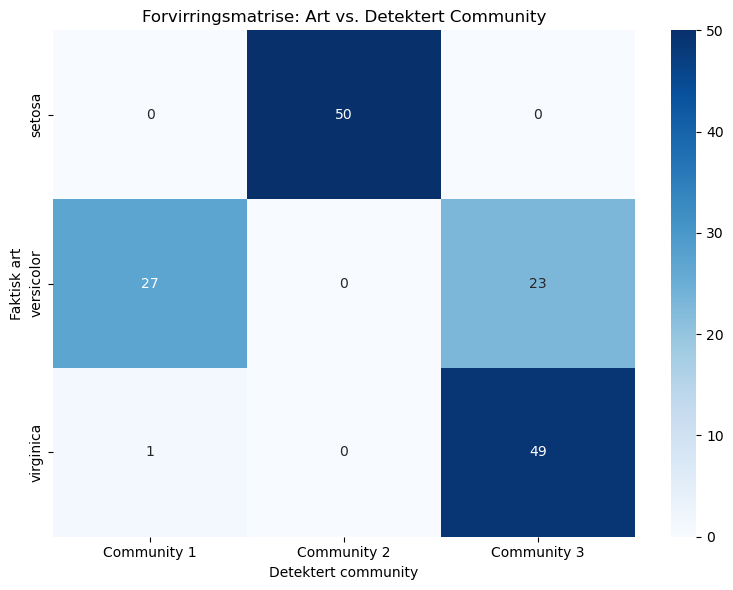


Nøyaktighet (beste tilordning): 84.0%


In [16]:
# Lag en "forvirringsmatrise" (confusion matrix)
cm = np.zeros((3, n_communities))
species_order = ['setosa', 'versicolor', 'virginica']

for comm_id, distribution in community_distribution.items():
    for i, species_name in enumerate(species_order):
        cm[i, comm_id] = distribution[species_name]

# Visualiser
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=[f'Community {i+1}' for i in range(n_communities)],
            yticklabels=species_order,
            ax=ax)

ax.set_title('Forvirringsmatrise: Art vs. Detektert Community', fontsize=12)
ax.set_ylabel('Faktisk art')
ax.set_xlabel('Detektert community')

plt.tight_layout()
plt.show()

# Beregn nøyaktighet (antar optimal tilordning av communities til arter)
# Finn beste match per community
best_matches = cm.max(axis=0).sum()
accuracy = best_matches / 150
print(f"\nNøyaktighet (beste tilordning): {accuracy:.1%}")


### 🎯 Tolkning

Forvirringsmatrisen viser oss:
- **Setosa** identifiseres perfekt – alle 50 i én community
- **Versicolor og Virginica** har noe overlapp – dette er forventet fordi disse artene faktisk har mer lignende egenskaper

Dette er et viktig funn: **nettverksbasert analyse kan avsløre naturlige grupperinger i data!**

**Klinisk relevans:** I pasientdata kan slike communities representere:
- Ulike sykdomssubtyper
- Pasienter med lignende behandlingsrespons
- Risikogrupper


---
## 📚 Oppsummering og neste steg

### Hva har vi lært?

1. **Bygge likhetsnettverk** – transformere feature-data til nettverksrepresentasjon
2. **Beregne likhet** – bruke Euklidsk avstand og transformasjon til likhetsmål
3. **Visualisere nettverk** – se strukturer og klynger i dataene
4. **Analysere nettverksegenskaper** – beregne metrikker og sammenligne grupper
5. **Community detection** – finne naturlige grupperinger automatisk

### Fra blomster til pasienter

Prinsippene vi har lært kan overføres direkte til kliniske data:

| IRIS-data | Pasientdata |
|-----------|-------------|
| Blomst | Pasient |
| Kronbladlengde, etc. | Labverdier, vitale tegn, etc. |
| Art (setosa, etc.) | Diagnose eller behandlingsrespons |
| Likhetsnettverk | Pasient-likhetsnettverk (PSN) |
| Community | Pasientsubgruppe |

### Neste notebook

I de neste notebookene skal vi anvende disse teknikkene på:
- Syntetiske pasientdata
- IQ-data fra ABCD-studien
- Mer avanserte likhetsmetrikker


---
## 💡 Øvelser

Prøv disse øvelsene for å fordype forståelsen:

### Øvelse 1: Alternativ likhetsmål
Modifiser koden til å bruke Gaussisk kjerne i stedet:
$$s_{ij} = \exp\left(-\frac{d_{ij}^2}{2\sigma^2}\right)$$

Hvordan påvirker valget av $\sigma$ nettverksstrukturen?

### Øvelse 2: Terskelbasert nettverk
I stedet for et komplett nettverk, lag et nettverk der kun kanter med likhet over en terskel (f.eks. 0.5) inkluderes. Hvordan endrer dette visualiseringen?

### Øvelse 3: Klinisk scenario
Tenk på en klinisk setting der du ville brukt PSN:
- Hvilke pasientvariabler ville du inkludert?
- Hvordan ville du vektet dem?
- Hva kunne communities representere?


---
## 📖 Referanser

- **Iris-datasettet**: Fisher, R.A. (1936). "The use of multiple measurements in taxonomic problems"
- **NetworkX**: Hagberg et al. (2008). "Exploring network structure, dynamics, and function using NetworkX"
- **Louvain community detection**: Blondel et al. (2008). "Fast unfolding of communities in large networks"
- **Patient Similarity Networks**: Pai & Bader (2018). "Patient Similarity Networks for Precision Medicine"
